### Imports

In [1]:
import os
import pandas as pd
import re
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure GPU is used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load data and clean

In [2]:
# Load the data
dataset_path = r'data\full_text\clean_tweets.csv'
data = pd.read_csv(dataset_path)
data = data[['TweetText', 'Closest_State']]

# Remove tweets with outside of thresholds)
data = data[data['TweetText'].str.split().str.len().between(15, 200)]
# Remove duplicate tweets
data = data.drop_duplicates(subset=['TweetText'])
# Normalize text
data['TweetText'] = data['TweetText'].str.lower().str.strip()
# Remove URLs
data['TweetText'] = data['TweetText'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
# Remove special characters, hashtags, mentions
data['TweetText'] = data['TweetText'].str.replace(r'[@#]\S+', '', regex=True)  # Remove hashtags and mentions
data['TweetText'] = data['TweetText'].str.replace(r'[^A-Za-z0-9\s]', '', regex=True)  # Remove non-alphanumeric characters


In [3]:
# Filter for states with at least 5,000 tweets
state_counts = data['Closest_State'].value_counts()
eligible_states = state_counts[state_counts >= 1000].index
data = data[data['Closest_State'].isin(eligible_states)]

# Encode the 'Closest_State' column
label_encoder = LabelEncoder()
data['state_id'] = label_encoder.fit_transform(data['Closest_State'])

# Split into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_data.to_csv(r"data\processed_tweets_train.csv", index=False)
val_data.to_csv(r"data\processed_tweets_val.csv", index=False)

In [4]:
# Print the state_id mappings
print("State to state_id mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


State to state_id mapping: {'Arizona': np.int64(0), 'California': np.int64(1), 'Connecticut': np.int64(2), 'Florida': np.int64(3), 'Georgia': np.int64(4), 'Illinois': np.int64(5), 'Louisiana': np.int64(6), 'Maryland': np.int64(7), 'Massachusetts': np.int64(8), 'Michigan': np.int64(9), 'New Jersey': np.int64(10), 'New York': np.int64(11), 'North Carolina': np.int64(12), 'Ohio': np.int64(13), 'Pennsylvania': np.int64(14), 'South Carolina': np.int64(15), 'Tennessee': np.int64(16), 'Texas': np.int64(17), 'Virginia': np.int64(18)}


In [5]:
#Load pfas_data
pfas_data_cleaned = pd.read_csv(r"data\pfas_data\merged_state_avg_arv.csv")

# Load processed tweet training data
train_tweet_data = pd.read_csv(r"data\processed_tweets_train.csv")

# Merge tweet data with PFAS data on 'state_id'
train_merged_data = pd.merge(train_tweet_data, pfas_data_cleaned, on='state_id', how='left')

# Fill any missing PFAS values with 0 (optional)
train_merged_data['AnalyticalResultValue'] = train_merged_data['AnalyticalResultValue'].fillna(0)

# Save the merged training dataset
train_merged_data.to_csv(r"data\train_with_pfas_data.csv", index=False)
print("Merged training data saved as 'train_with_pfas_data.csv'.")

# Load processed tweet validation data
val_tweet_data = pd.read_csv(r"data\processed_tweets_val.csv")

# Merge validation data with PFAS data on 'state_id'
val_merged_data = pd.merge(val_tweet_data, pfas_data_cleaned, on='state_id', how='left')

# Fill any missing PFAS values with 0 (optional)
val_merged_data['AnalyticalResultValue'] = val_merged_data['AnalyticalResultValue'].fillna(0)

# Save the merged validation dataset
val_merged_data.to_csv(r"data\val_with_pfas_data.csv", index=False)
print("Merged validation data saved as 'val_with_pfas_data.csv'.")

# Load and inspect the final training data
final_train_data = pd.read_csv(r"data\train_with_pfas_data.csv")
print(final_train_data.head())

# Inspect the validation data
final_val_data = pd.read_csv(r"data\val_with_pfas_data.csv")
print(final_val_data.head())


Merged training data saved as 'train_with_pfas_data.csv'.
Merged validation data saved as 'val_with_pfas_data.csv'.
                                           TweetText Closest_State  state_id  \
0  there is a tutorial thingy that should walk u ...       Georgia         4   
1  rt  so my cousin new gfs bad hmm time to steal...      New York        11   
2   if u paid 150 on ur hair and soon as u leave ...    California         1   
3  my day so far consisted of work and then nap i...    New Jersey        10   
4  the bears want em thats crazy he needs to go t...      New York        11   

   AnalyticalResultValue  
0               0.322682  
1               0.374170  
2               0.484683  
3               0.339042  
4               0.374170  
                                           TweetText Closest_State  state_id  \
0  i bet u will think twice b4 u fall to sleep in...      New York        11   
1  guess ima go in my room and watch tvgod please...       Georgia         4   
2

In [24]:
# Reload the merged training and validation datasets
train_data = pd.read_csv(r"data\train_with_pfas_data.csv")
val_data = pd.read_csv(r"data\val_with_pfas_data.csv")

# Debugging
# print("Columns in training data:", train_data.columns)
# print("Columns in validation data:", val_data.columns)

### Tokenizer

In [25]:
# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize the dataset
def tokenize_data(data, max_seq_len=50):
    # Tokenize the text column
    encodings = tokenizer(
        data['TweetText'].tolist(),
        padding="max_length",    # Pads sequences to the max length
        truncation=True,         # Truncates sequences longer than max_seq_len
        max_length=max_seq_len,  # Maximum sequence length
        return_tensors="pt"      # Return PyTorch tensors
    )
    
    # Extract the PFAS values as tensors
    pfas_values = torch.tensor(data['AnalyticalResultValue'].values, dtype=torch.float32).unsqueeze(1)  # Shape: [batch_size, 1]
    
    return encodings, pfas_values

# Tokenize the training and validation datasets
train_encodings, train_pfas = tokenize_data(train_data, max_seq_len=50)
val_encodings, val_pfas = tokenize_data(val_data, max_seq_len=50)

# Convert labels to tensors
train_labels = torch.tensor(train_data['state_id'].values, dtype=torch.long)
val_labels = torch.tensor(val_data['state_id'].values, dtype=torch.long)


### GeoTextDataset

In [26]:
def collate_fn(batch):
    # Stack tokenized inputs and labels
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    pfas_values = torch.stack([item['pfas'] for item in batch])  # PFAS data

    # Preserve original tweet texts as a list
    tweet_texts = [item['TweetText'] for item in batch]

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'pfas': pfas_values,
        'TweetText': tweet_texts
    }


In [27]:
class GeoTextDataset(Dataset):
    def __init__(self, encodings, labels, texts, pfas_values):
        self.encodings = encodings  # Pre-tokenized data (input_ids, attention_mask)
        self.labels = labels        # Corresponding labels
        self.texts = texts          # Original tweet texts
        self.pfas_values = pfas_values  # PFAS data as tensors

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Retrieve tokenized data
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]  # Add label
        item['TweetText'] = self.texts[idx]  # Include original tweet text
        item['pfas'] = self.pfas_values[idx]  # Add PFAS data
        return item


In [28]:
train_texts = train_data['TweetText'].tolist()
val_texts = val_data['TweetText'].tolist()

# PFAS values as tensors
train_pfas = torch.tensor(train_data['AnalyticalResultValue'].values, dtype=torch.float32).unsqueeze(1)
val_pfas = torch.tensor(val_data['AnalyticalResultValue'].values, dtype=torch.float32).unsqueeze(1)

# Create datasets
train_dataset = GeoTextDataset(train_encodings, train_labels, train_texts, train_pfas)
val_dataset = GeoTextDataset(val_encodings, val_labels, val_texts, val_pfas)

# Create DataLoaders with the updated collate function
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


### RoBERTa Model With CNN

In [32]:
class GeoTextModelWithCNN(nn.Module):
    def __init__(self, text_embedding_dim, num_states, kernel_sizes=(2, 3, 4), num_filters=64):
        super(GeoTextModelWithCNN, self).__init__()
        self.text_encoder = RobertaModel.from_pretrained("roberta-base")
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, text_embedding_dim)) for k in kernel_sizes
        ])
        
        self.fc_cnn = nn.Linear(len(kernel_sizes) * num_filters, 128)
        self.fc_pfas = nn.Linear(1, 128)  
        self.fc_pfas_predict = nn.Linear(128 + 128, 1) 
        self.fc_combined = nn.Linear(128 + 128, num_states)
    
    def forward(self, input_ids, attention_mask, pfas_levels):
        # Existing text and CNN processing
        text_embedding = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        text_embedding = text_embedding.unsqueeze(1)  # Add channel dimension (for CNN)
        
        cnn_features = [torch.relu(conv(text_embedding)).squeeze(3) for conv in self.convs]
        cnn_features = [torch.max(f, dim=2)[0] for f in cnn_features]
        cnn_output = torch.cat(cnn_features, dim=1)
        cnn_output = self.fc_cnn(cnn_output)
        
        # PFAS feature processing
        pfas_output = torch.relu(self.fc_pfas(pfas_levels))
    
        # Combine features
        combined_output = torch.cat((cnn_output, pfas_output), dim=1)
    
        # Predict state
        logits_state = self.fc_combined(combined_output)
    
        # Predict PFAS level
        logits_pfas = self.fc_pfas_predict(combined_output)
    
        # Return both predictions
        return logits_state, logits_pfas

In [37]:
#Debugging

# outputs = model(input_ids=input_ids, attention_mask=attention_mask, pfas_levels=pfas_levels)
# print(type(outputs), outputs.shape if isinstance(outputs, torch.Tensor) else None)

# print("tweet_texts:", len(tweet_texts))
# print("labels:", labels.shape)
# print("predicted_states:", predicted_states.shape)
# print("pfas_levels:", pfas_levels.shape)
# print("predicted_pfas:", predicted_pfas.shape)


<class 'tuple'> None
tweet_texts: 16
labels: torch.Size([16])
predicted_states: (16,)
pfas_levels: torch.Size([16, 1])
predicted_pfas: (16,)


In [35]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        Focal Loss Implementation
        :param alpha: Scaling factor for class imbalance (can be a scalar or a tensor of class weights)
        :param gamma: Focusing parameter to down-weight easy examples
        :param reduction: 'mean', 'sum', or 'none' for how to reduce the loss
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        :param logits: Model outputs before applying softmax (shape: [batch_size, num_classes])
        :param targets: Ground truth class indices (shape: [batch_size])
        :return: Computed focal loss
        """
        # Apply softmax to get probabilities
        probs = F.softmax(logits, dim=1)
        
        # Get the probabilities corresponding to the true class
        targets_one_hot = F.one_hot(targets, num_classes=logits.size(1))
        probs = (probs * targets_one_hot).sum(dim=1)  # Select probabilities for the correct class
        
        # Compute focal loss
        focal_loss = -self.alpha * (1 - probs) ** self.gamma * torch.log(probs + 1e-9)
        
        # Reduce loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


### Run the training

In [43]:
# Training and Validation
criterion = FocalLoss(alpha=1, gamma=2, reduction='mean')
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Early Stopping Parameters
early_stop_patience = 2  # Stop if no improvement for these many epochs
best_val_accuracy = 0
patience_counter = 0

train_losses = []
val_accuracies = []
epochs = 10

# Path to save the best model
best_model_path = r"model\geotext_modelcnn.pth"

# Path to save predictions
train_predictions_file = r"data\predictions\train_predictions.csv"
val_predictions_file = r"data\predictions\val_predictions.csv"

# Track if headers are written
train_header_saved = False
val_header_saved = False

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # ===== TRAINING LOOP =====
    model.train()
    total_loss = 0
    train_loader_with_progress = tqdm(train_loader, desc="Training", leave=False)

    for batch in train_loader_with_progress:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pfas_levels = batch["pfas"].to(device)  # Include PFAS levels
        labels = batch["labels"].to(device)
        tweet_texts = batch["TweetText"]  # Access the tweet texts

        # Forward pass
        optimizer.zero_grad()
        logits_state, logits_pfas = model(input_ids=input_ids, attention_mask=attention_mask, pfas_levels=pfas_levels)

        # Compute losses
        loss_state = criterion(logits_state, labels)  # Classification loss for state
        loss_pfas = F.mse_loss(logits_pfas.squeeze(), pfas_levels.squeeze())  # Regression loss for PFAS levels
        loss = loss_state + loss_pfas  # Combine losses

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Save predictions incrementally
        with torch.no_grad():
            predicted_states = torch.argmax(logits_state, dim=1).cpu().numpy()
            predicted_pfas = logits_pfas.squeeze().cpu().numpy()  # Predicted PFAS levels
            batch_results = pd.DataFrame({
                'text': tweet_texts,  # Save the TweetText
                'true_state': labels.cpu().numpy(),
                'predicted_state': predicted_states,
                'true_pfas': pfas_levels.squeeze().cpu().numpy(),
                'predicted_pfas': predicted_pfas 
            })

            # Write batch predictions to file
            if not train_header_saved:
                batch_results.to_csv(train_predictions_file, index=False, mode='w')  # Overwrite and write header
                train_header_saved = True
            else:
                batch_results.to_csv(train_predictions_file, index=False, mode='a', header=False)  # Append without header

    train_losses.append(total_loss)
    print(f"Epoch {epoch + 1} Loss: {total_loss:.4f}")

    # ===== VALIDATION LOOP =====
    model.eval()
    correct = 0
    total = 0
    val_loader_with_progress = tqdm(val_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for batch in val_loader_with_progress:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pfas_levels = batch["pfas"].to(device)  # Include PFAS levels
            labels = batch["labels"].to(device)
            tweet_texts = batch["TweetText"]  # Access the tweet texts

            logits_state, logits_pfas = model(input_ids=input_ids, attention_mask=attention_mask, pfas_levels=pfas_levels)

            # Calculate accuracy for state predictions
            predictions = torch.argmax(logits_state, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Save validation predictions incrementally
            predicted_states = predictions.cpu().numpy()
            predicted_pfas = logits_pfas.squeeze().cpu().numpy()
            batch_results = pd.DataFrame({
                'text': tweet_texts,
                'true_state': labels.cpu().numpy(),
                'predicted_state': predicted_states,
                'true_pfas': pfas_levels.squeeze().cpu().numpy(),
                'predicted_pfas': predicted_pfas
            })

            # Write batch predictions to file
            if not val_header_saved:
                batch_results.to_csv(val_predictions_file, index=False, mode='w')  # Overwrite and write header
                val_header_saved = True
            else:
                batch_results.to_csv(val_predictions_file, index=False, mode='a', header=False)  # Append without header

        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Early stopping check
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0  # Reset patience counter
            torch.save(model.state_dict(), best_model_path)  # Save the best model
            print("Validation accuracy improved, model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation accuracy. Patience counter: {patience_counter}/{early_stop_patience}")

        if patience_counter >= early_stop_patience:
            print(f"Early stopping triggered. Stopping training after epoch {epoch + 1}.")
            break  # Stop training early


C:\Users\lemon\anaconda3\envs\test_env_gpu\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/10


Epoch 1 Loss: 7315.2834


Validation Accuracy: 0.3820
Validation accuracy improved, model saved.
Epoch 2/10


Epoch 2 Loss: 7074.5566


Validation Accuracy: 0.3820
No improvement in validation accuracy. Patience counter: 1/2
Epoch 3/10


Epoch 3 Loss: 6876.8680


Validation Accuracy: 0.5293
Validation accuracy improved, model saved.
Epoch 4/10


Epoch 4 Loss: 6702.5545


Validation Accuracy: 0.3820
No improvement in validation accuracy. Patience counter: 1/2
Epoch 5/10


Epoch 5 Loss: 6553.6371


Validation Accuracy: 0.3820
No improvement in validation accuracy. Patience counter: 2/2
Early stopping triggered. Stopping training after epoch 5.


In [44]:
train_predictions_file = r"data\predictions\train_predictions.csv"
val_predictions_file = r"data\predictions\val_predictions.csv"

# Load predictions
train_preds = pd.read_csv(train_predictions_file)
val_preds = pd.read_csv(val_predictions_file)

# Compute metrics for validation predictions
y_true = val_preds['true_state']
y_pred = val_preds['predicted_state']

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Compute Micro and Macro F1 Scores
micro_f1 = f1_score(y_true, y_pred, average='micro')
macro_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Micro F1 Score: {micro_f1:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")

# Precision and Recall
micro_precision = precision_score(y_true, y_pred, average='micro')
macro_precision = precision_score(y_true, y_pred, average='macro')
micro_recall = recall_score(y_true, y_pred, average='micro')
macro_recall = recall_score(y_true, y_pred, average='macro')

print(f"Micro Precision: {micro_precision:.4f}, Micro Recall: {micro_recall:.4f}")
print(f"Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1190
           1       0.63      1.00      0.78      9675
           2       0.00      0.00      0.00      1605
           3       0.00      0.00      0.00      5410
           4       0.00      0.00      0.00      7510
           5       0.00      0.00      0.00      2535
           6       0.00      0.00      0.00      1005
           7       0.00      0.00      0.00      4765
           8       0.00      0.00      0.00      1210
           9       0.00      0.00      0.00      2625
          10       0.16      0.20      0.18     13715
          11       0.37      1.00      0.54     20025
          12       0.00      0.00      0.00      3965
          13       0.00      0.00      0.00      3595
          14       0.00      0.00      0.00      2060
          15       0.00      0.00      0.00      1605
          16       0.00      0.00      0.00      1570
    

C:\Users\lemon\anaconda3\envs\test_env_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lemon\anaconda3\envs\test_env_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lemon\anaconda3\envs\test_env_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

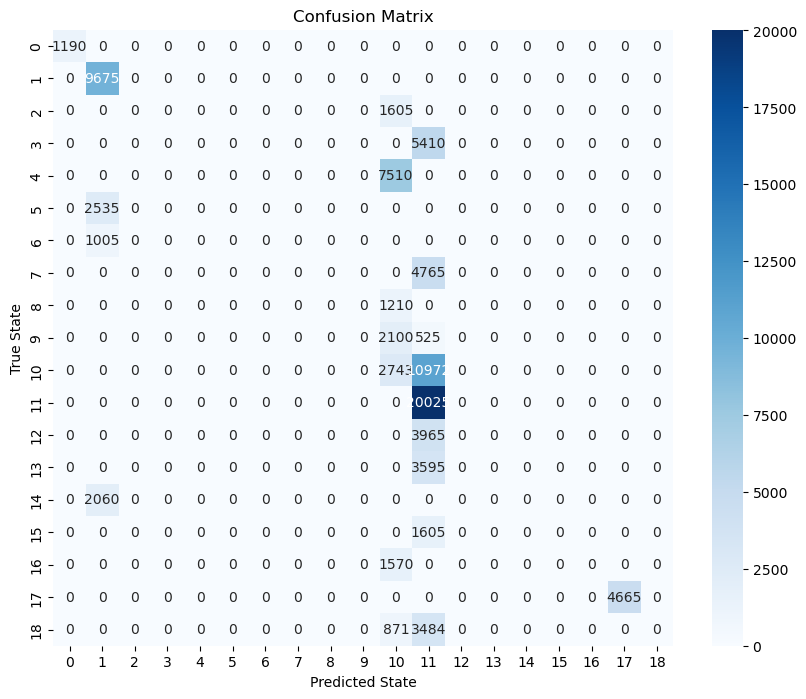

In [45]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
plt.xlabel("Predicted State")
plt.ylabel("True State")
plt.title("Confusion Matrix")
plt.show()


In [46]:
# Filter incorrect predictions for state and PFAS levels
error_cases = val_preds[
    (val_preds['true_state'] != val_preds['predicted_state']) |  # Mismatched states
    (np.abs(val_preds['true_pfas'] - val_preds['predicted_pfas']) > 0.1)  # Significant PFAS level errors
]

# Display sample error cases
print("Sample Error Cases:")
print(error_cases[['text', 'true_state', 'predicted_state', 'true_pfas', 'predicted_pfas']].head())
error_cases.to_csv(r"data\predictions\val_error_cases.csv", index=False)


Sample Error Cases:
                                                 text  true_state  \
1   guess ima go in my room and watch tvgod please...           4   
4   val u have like triple gs plz go in ur room an...           7   
6   rt  puffin kushwhat else is new im jus rollin ...           8   
8   ya know how ya get in trouble ya moms went to ...           3   
10  lmao rt  after a drunk night i love reading my...           5   

    predicted_state  true_pfas  predicted_pfas  
1                10   0.322682        0.318739  
4                11   0.359763        0.355867  
6                10   0.316810        0.312859  
8                11   0.340777        0.336857  
10                1   0.459714        0.455944  


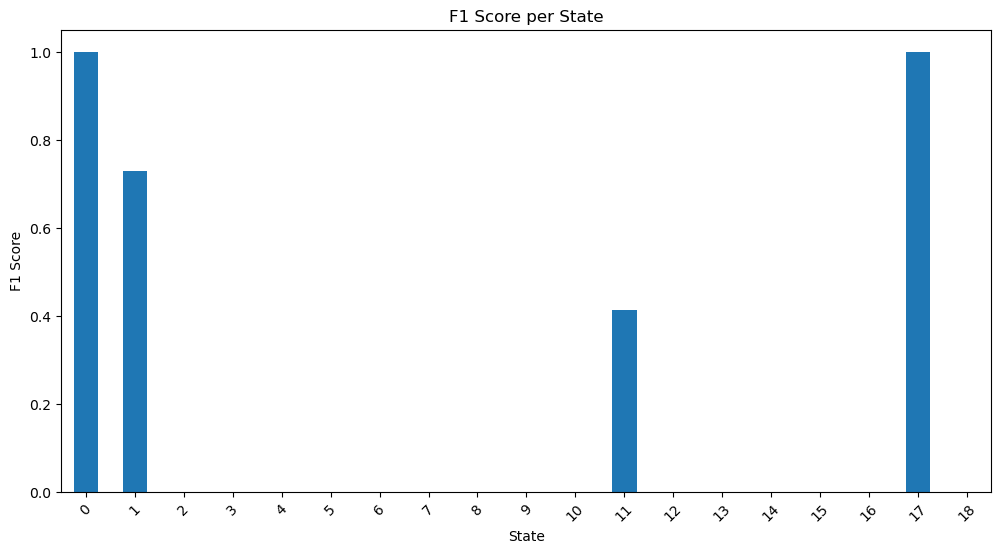

In [47]:
# Plot F1 scores for each state
df_report = df_report[df_report.index.isin(y_true.unique())]  # Filter for relevant states
df_report['f1-score'].plot(kind='bar', figsize=(12, 6), title="F1 Score per State")
plt.xlabel("State")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.show()
